# Transport GNN

## Training a GCN Using pytorch


In this notebook my goal was to build a graph neural network to classify different nodes from a traffic flow dataset. 

In the specific file i was working on there are only about 200 node connections.

There are 2 features and one labels columns where i placed the congestion factor numbers into 4 bins.

## Visualizing the nodes

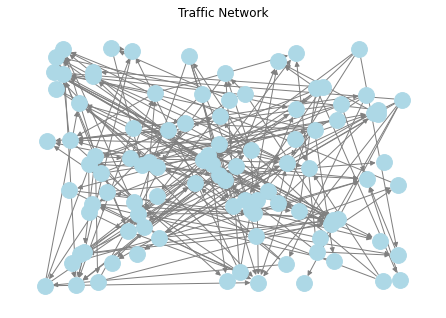

,source,target,vehicles,speed,congestion_factor
0,0,90,22,22.831590,3.13
1,0,41,42,-3.298611,3.85
2,1,61,3,18.794954,2.47
3,1,89,92,22.565532,2.93
4,1,66,37,-6.038235,2.70


In [29]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


G = nx.DiGraph()

data = pd.read_csv("datasets/transport-gnn/traffic_flow_data.csv")

for index , row in data.iterrows():
    G.add_edge(row["source"] , row["target"])

# pos = nx.spring_layout(G)
pos = nx.random_layout(G)

nx.draw(G, pos , with_labels=False , node_size=250 , node_color="lightblue" , 
       edge_color="gray") 

plt.title("Traffic Network")

plt.show()

data.head()

## Data processing

In [21]:
import torch 
from torch_geometric.data import Data 
import torch.nn as nn
import pandas as pd

# load the dataset
df = pd.read_csv("datasets/transport-gnn/traffic_flow_data.csv")

# seperate edge indexs and create the tensor
source = df["source"]
destination = df["target"]

edge_index = [[source[i], destination[i]] for i in range(len(source))]
edge_index = torch.tensor(edge_index).view(-1, 2)


# create the classifation labels
bins = [1.2, 2.0, 3.0, 4.0, 4.8]

df["congestion_factor"] = pd.to_numeric(df["congestion_factor"])
df["congestion_factor"] = df["congestion_factor"].fillna(0)
df["congestion_factor"] = pd.cut(df["congestion_factor"], bins=bins, labels=[1, 2, 3, 4])


# creating labels and features tensors
labels = df["congestion_factor"]
features = df.drop("congestion_factor" , axis=1)

features_tensor = torch.tensor(features.values, dtype=torch.float32)  # Assuming numerical features
labels_tensor = torch.tensor(labels.values, dtype=torch.long)  # Assuming integer labels



data = Data(x=features_tensor, y=labels_tensor , edge_index=edge_index.t().contiguous() ,
            train_mask = 140,test_mask = 30 ,num_classes = 4)

print(data.x[0])

tensor([ 0.0000, 90.0000, 22.0000, 22.8316])


## Convolution Neural Network

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN()

print(model)

## Testing and Evaluation

In [27]:
data_ = data
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data_)
    loss = F.nll_loss(out[data_.train_mask], data_.y[data_.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / data.test_mask
print(correct)
# acc = correct / torch.tensor(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

tensor(0)
Accuracy: 0.0000
